In [10]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold,KFold, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)


In [3]:
# train = pd.read_csv('data/Train.csv')
# test = pd.read_csv('data/Test.csv')

# test_id = test['ID_Zindi']
# pd.options.display.max_columns = 200

In [4]:
train.head()


In [5]:
# id = set(train['ID'])

In [11]:
data = pd.read_csv('data/Train.csv')


In [12]:
numeric_columns = ['Precipitation', 'LST', 'AAI', 'CloudFraction', 'NO2_strat',
                   'NO2_total', 'NO2_trop', 'TropopausePressure', 'GT_NO2']
for col in numeric_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')
use_col = ['Precipitation', 'LST', 'AAI', 'CloudFraction', 'NO2_strat', 'NO2_total', 'NO2_trop', 'TropopausePressure']

In [13]:
# Set 'Date' as the index
data.set_index('Date', inplace=True)

# Verify that the index is a DatetimeIndex
print(type(data.index))


<class 'pandas.core.indexes.base.Index'>


In [14]:

data = data[use_col + ['ID', 'GT_NO2']]

data.head()

,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,ID,GT_NO2
Date,,,,,,,,,,
1/1/19,0.000000,NaN,0.230527,0.559117,0.000024,0.000117,NaN,14440.82126,PD01,31.0
1/1/19,3.047342,NaN,-0.074006,0.869309,0.000024,0.000127,NaN,14441.79815,PD04,42.0
1/1/19,0.000000,NaN,0.024470,0.674160,0.000024,0.000086,NaN,14437.38294,RO01,31.0
1/1/19,1.200467,NaN,-0.010442,0.920054,0.000024,0.000124,NaN,14440.83831,RO02,30.0
1/1/19,1.274564,NaN,-0.176178,0.747464,0.000024,0.000116,NaN,14438.79037,RO03,58.0


In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# 'Precipitation', 'LST', 'AAI', 'CloudFraction', 'NO2_strat', 'NO2_total', 'NO2_trop', 'TropopausePressure'
data[use_col] = scaler.fit_transform(data[use_col])

In [16]:
data = data.sort_values('Date')

grouped = data.groupby('ID')

In [17]:
data = pd.read_csv('data/Train.csv')

unique_ids = data['ID'].unique()
model_results = {}
for uid in unique_ids:
    id_data = data[data['ID'] == uid].copy()
    id_data['Date'] = pd.to_datetime(id_data['Date'])
    # Set 'Date' as index and sort
    id_data.set_index('Date', inplace=True)
    id_data.sort_index(inplace=True)
    id_data = id_data.asfreq('D')

    # Handle missing values
    id_data.interpolate(method='time', inplace=True)
    id_data.fillna(method='ffill', inplace=True)
    id_data.fillna(method='bfill', inplace=True)

    # Check the number of observations
    print(f"Number of observations for ID PD01: {len(id_data)}")
    
    train = id_data[id_data.index.year <= 2020]
    test = id_data[id_data.index.year > 2020]
    print(f"Training data length for ID PD01: {len(train)}")
    print(f"Testing data length for ID PD01: {len(test)}")
    
    exog_vars = use_col

    # Prepare exogenous variables
    X_train = train[exog_vars]
    X_test = test[exog_vars]

    # Check shapes
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    
    y_train = train['GT_NO2']
    y_test = test['GT_NO2']

    print(f"y_train shape: {y_train.shape}")
    print(f"y_test shape: {y_test.shape}")
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    
    # Ensure indices are aligned
    X_train = X_train.loc[y_train.index]
    X_test = X_test.loc[y_test.index]

    # Fit the SARIMAX model
    model = SARIMAX(y_train, exog=X_train, order=(1,1,1), seasonal_order=(1,1,1,7))
    sarimax_model = model.fit(disp=False)

    # Forecast
    forecast = sarimax_model.predict(start=y_test.index[0], end=y_test.index[-1], exog=X_test)

    # Evaluate the model
    mae = mean_absolute_error(y_test, forecast)
    rmse = np.sqrt(mean_squared_error(y_test, forecast))

    print(f"ID {uid} - MAE: {mae:.2f}, RMSE: {rmse:.2f}")
    
    # Store the model and metrics
    model_results[uid] = {
        'uid': uid, 
        'model': sarimax_model,
        'mae': mae,
        'rmse': rmse,
        'y_train': y_train,
        'y_test': y_test,
        'forecast': forecast
    }

    # # Plot the results
    # plt.figure(figsize=(12, 6))
    # plt.plot(y_train.index, y_train, label='Training Data')
    # plt.plot(y_test.index, y_test, label='Actual Data')
    # plt.plot(forecast.index, forecast, label='Forecasted Data')
    # plt.title(f'GT_NO₂ Forecast with Exogenous Variables for ID {uid}')
    # plt.xlabel('Date')
    # plt.ylabel('GT_NO₂')
    # plt.legend()
    # plt.show()

Number of observations for ID PD01: 1096
Training data length for ID PD01: 731
Testing data length for ID PD01: 365
X_train shape: (731, 8)
X_test shape: (365, 8)
y_train shape: (731,)
y_test shape: (365,)
ID PD01 - MAE: 4.55, RMSE: 5.88
Number of observations for ID PD01: 1096
Training data length for ID PD01: 731
Testing data length for ID PD01: 365
X_train shape: (731, 8)
X_test shape: (365, 8)
y_train shape: (731,)
y_test shape: (365,)
ID PD04 - MAE: 10.17, RMSE: 11.92
Number of observations for ID PD01: 1096
Training data length for ID PD01: 731
Testing data length for ID PD01: 365
X_train shape: (731, 8)
X_test shape: (365, 8)
y_train shape: (731,)
y_test shape: (365,)
ID RO01 - MAE: 5.27, RMSE: 7.68
Number of observations for ID PD01: 1096
Training data length for ID PD01: 731
Testing data length for ID PD01: 365
X_train shape: (731, 8)
X_test shape: (365, 8)
y_train shape: (731,)
y_test shape: (365,)
ID RO02 - MAE: 7.56, RMSE: 9.00
Number of observations for ID PD01: 1096
Train

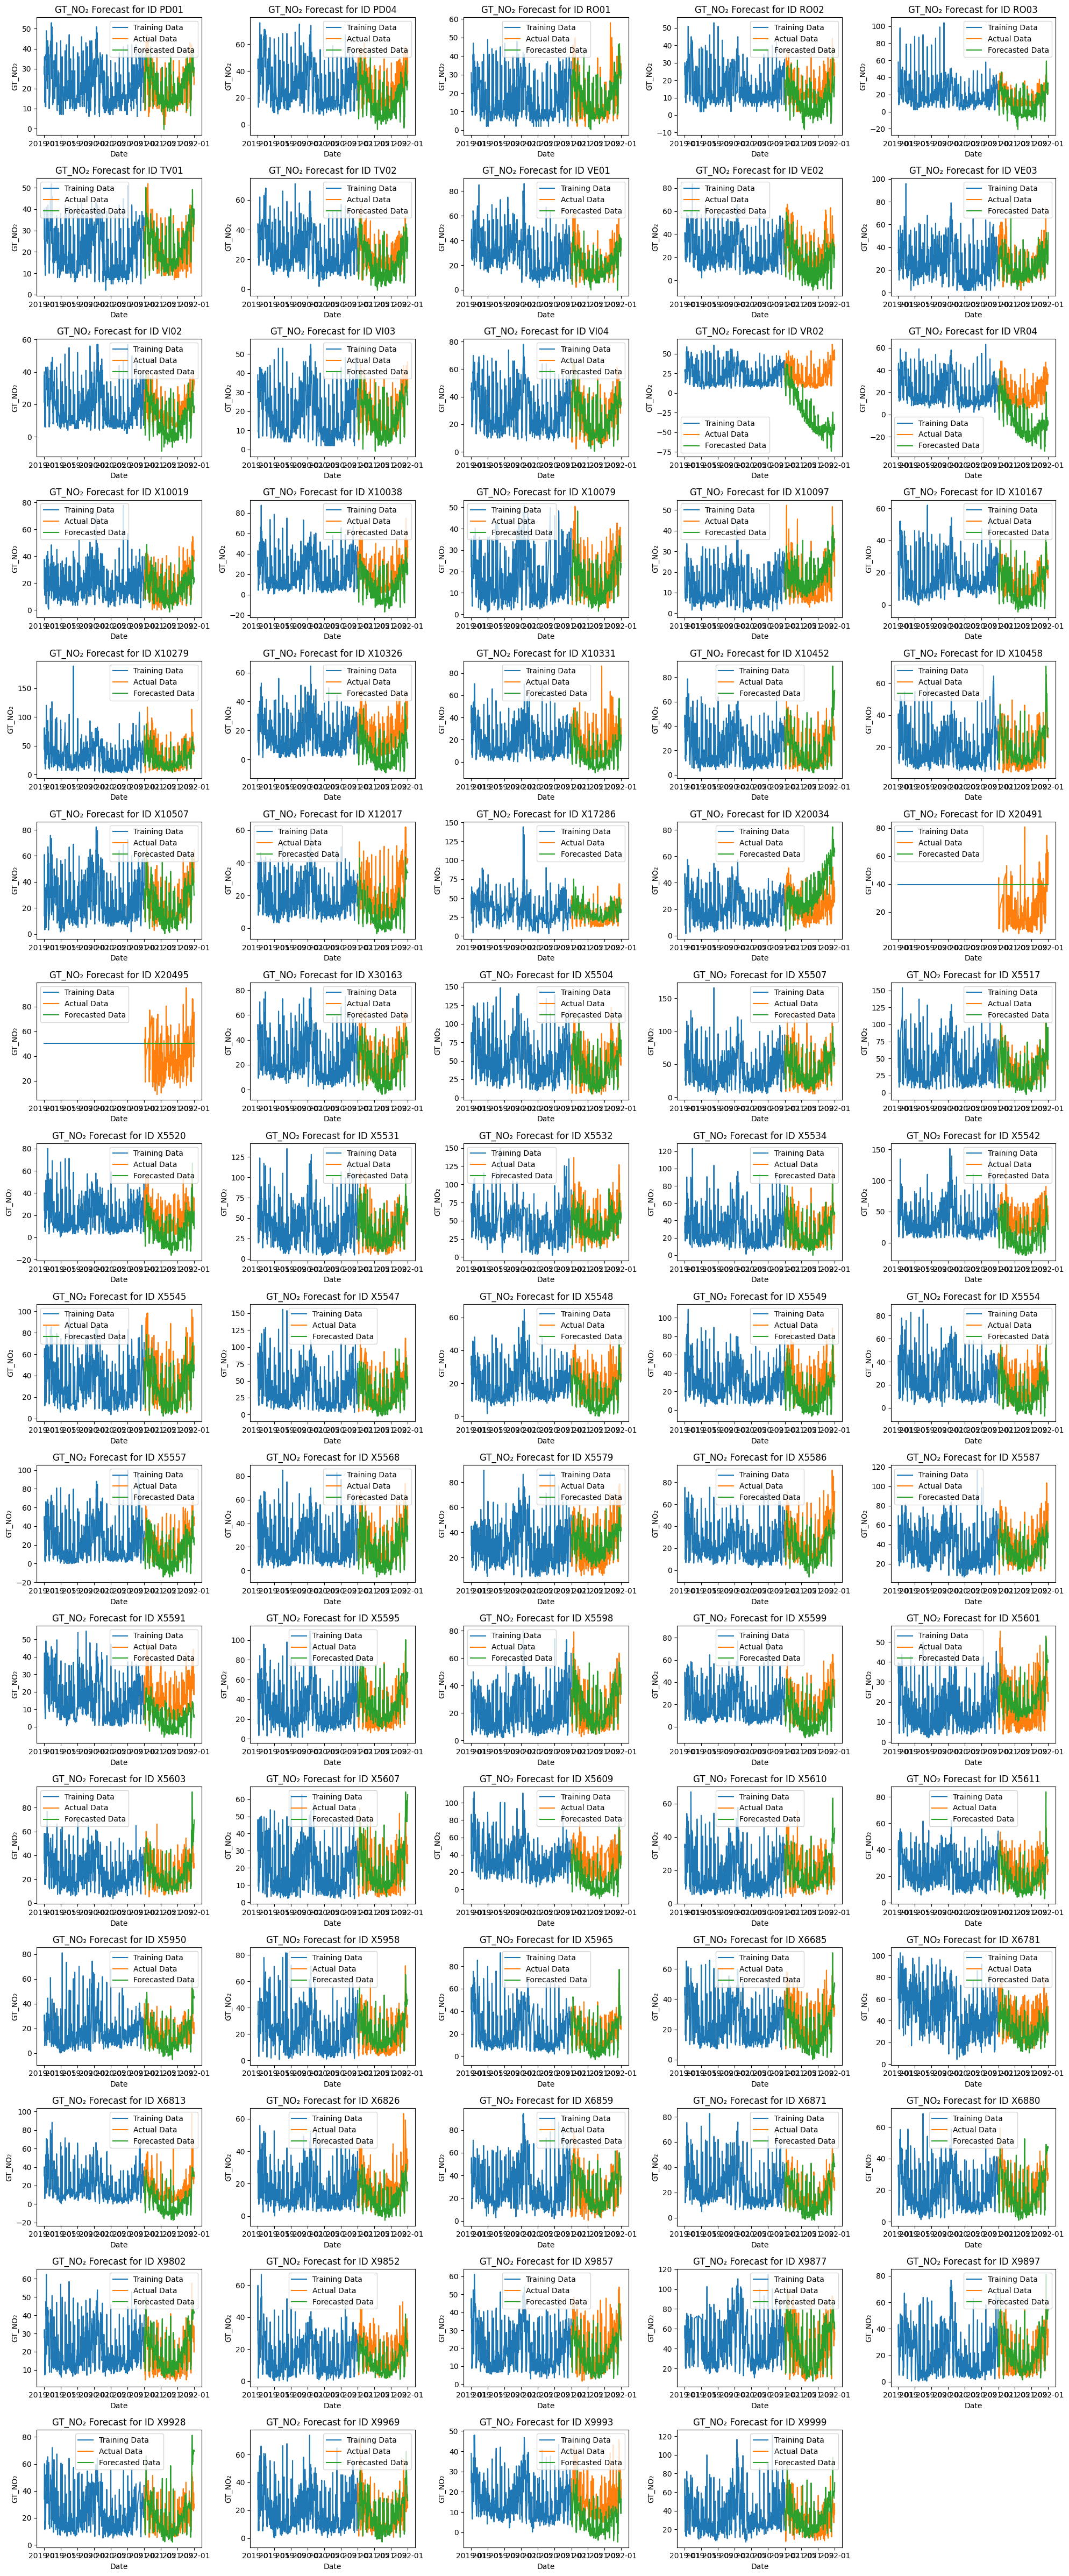

TypeError: string indices must be integers

In [18]:
import matplotlib.pyplot as plt

# Get all the UIDs
uids = list(model_results.keys())

# Define the number of graphs per row
graphs_per_row = 5

# Calculate the total number of rows needed
total_graphs = len(uids)
rows = (total_graphs + graphs_per_row - 1) // graphs_per_row  # Ceiling division

# Create subplots
fig, axes = plt.subplots(rows, graphs_per_row, figsize=(graphs_per_row * 4, rows * 3))
axes = axes.flatten()  # Flatten in case of multiple rows

# Loop through each UID and plot
for i, uid in enumerate(uids):
    ax = axes[i]
    result = model_results[uid]
    y_train = result['y_train']
    y_test = result['y_test']
    forecast = result.get('forecast')  # Ensure 'forecast' exists

    # Plot the data
    ax.plot(y_train.index, y_train, label='Training Data')
    ax.plot(y_test.index, y_test, label='Actual Data')
    if forecast is not None:
        ax.plot(forecast.index, forecast, label='Forecasted Data')
    ax.set_title(f'GT_NO₂ Forecast for ID {uid}')
    ax.set_xlabel('Date')
    ax.set_ylabel('GT_NO₂')
    ax.legend()

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [21]:
mae = 0
rmse = 0
for i in model_results:
    mae += model_results[i]['mae']
    rmse += model_results[i]['rmse']

print(f"MAE: {mae/len(model_results):.2f}, RMSE: {rmse/len(model_results):.2f}")

MAE: 9.94, RMSE: 12.38


In [15]:
# import numpy as np

# # Select numeric columns
# numeric_cols = data.select_dtypes(include=[np.number]).columns

# # Perform time-based interpolation on numeric columns
# data[numeric_cols] = data[numeric_cols].interpolate(method='time')

ValueError: time-weighted interpolation only works on Series or DataFrames with a DatetimeIndex

In [9]:
data.head()

,ID_Zindi,ID,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,GT_NO2
Date,,,,,,,,,,,,,
1/1/19,ID_ENTGC7,PD01,45.601585,11.903551,0.000000,NaN,0.230527,0.559117,0.000024,0.000117,NaN,14440.82126,31.0
1/1/19,ID_8JCCXC,PD04,45.371005,11.840830,3.047342,NaN,-0.074006,0.869309,0.000024,0.000127,NaN,14441.79815,42.0
1/1/19,ID_V3136Z,RO01,45.045825,12.060869,0.000000,NaN,0.024470,0.674160,0.000024,0.000086,NaN,14437.38294,31.0
1/1/19,ID_KRVZDJ,RO02,45.104075,11.553241,1.200467,NaN,-0.010442,0.920054,0.000024,0.000124,NaN,14440.83831,30.0
1/1/19,ID_PR351A,RO03,45.038758,11.790152,1.274564,NaN,-0.176178,0.747464,0.000024,0.000116,NaN,14438.79037,58.0


In [10]:
# data['Month'] = data.index.month
# data['DayOfWeek'] = data.index.dayofweek
# data['DayOfYear'] = data.index.dayofyear

AttributeError: 'Index' object has no attribute 'month'

In [6]:
data.head()

,ID_Zindi,ID,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,GT_NO2
Date,,,,,,,,,,,,,
1/1/19,ID_ENTGC7,PD01,45.601585,11.903551,0.000000,NaN,0.230527,0.559117,0.000024,0.000117,NaN,14440.82126,31.0
1/1/19,ID_8JCCXC,PD04,45.371005,11.840830,3.047342,NaN,-0.074006,0.869309,0.000024,0.000127,NaN,14441.79815,42.0
1/1/19,ID_V3136Z,RO01,45.045825,12.060869,0.000000,NaN,0.024470,0.674160,0.000024,0.000086,NaN,14437.38294,31.0
1/1/19,ID_KRVZDJ,RO02,45.104075,11.553241,1.200467,NaN,-0.010442,0.920054,0.000024,0.000124,NaN,14440.83831,30.0
1/1/19,ID_PR351A,RO03,45.038758,11.790152,1.274564,NaN,-0.176178,0.747464,0.000024,0.000116,NaN,14438.79037,58.0


In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_to_scale = []
# 'Precipitation', 'LST', 'AAI', 'CloudFraction', 'NO2_strat', 'NO2_total', 'NO2_trop', 'TropopausePressure'
data[features_to_scale] = scaler.fit_transform(data[features_to_scale])


ValueError: at least one array or dtype is required

In [31]:
data = data[['ID', 'GT_NO2']]

data.head()

,ID,GT_NO2
Date,,
1/1/19,PD01,31.0
1/1/19,PD04,42.0
1/1/19,RO01,31.0
1/1/19,RO02,30.0
1/1/19,RO03,58.0


In [33]:
data = data.sort_values('Date')

grouped = data.groupby('ID')
# Step 4: Plot Each Group Individually
# for name, group in grouped:
    # plt.figure(figsize=(10, 6))
    
#     # Plot the desired variables; adjust these as needed
#     plt.plot(group.index, group['GT_NO2'], label='GT_NO2')
    
#     plt.title(f'Variables Over Time for ID {name}')
#     plt.xlabel('Date')
#     plt.ylabel('Value')
#     plt.legend()
#     plt.show()


In [10]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(14,6))
# plt.plot(data['GT_NO2'])
# plt.title('GT_NO₂ Levels Over Time')
# plt.xlabel('Date')
# plt.ylabel('GT_NO₂')
# plt.show()


In [34]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


In [37]:
data = pd.read_csv('data/Train.csv')

unique_ids = data['ID'].unique()
model_results = {}
for uid in unique_ids:
    id_data = data[data['ID'] == uid].copy()
    id_data['Date'] = pd.to_datetime(id_data['Date'])
    # Set 'Date' as index and sort
    id_data.set_index('Date', inplace=True)
    id_data.sort_index(inplace=True)
    id_data = id_data.asfreq('D')

    # Handle missing values
    id_data.interpolate(method='time', inplace=True)
    id_data.fillna(method='ffill', inplace=True)
    id_data.fillna(method='bfill', inplace=True)

    # Check the number of observations
    print(f"Number of observations for ID PD01: {len(id_data)}")
    
    train = id_data[id_data.index.year <= 2020]
    test = id_data[id_data.index.year > 2020]
    print(f"Training data length for ID PD01: {len(train)}")
    print(f"Testing data length for ID PD01: {len(test)}")
    
    exog_vars = []

    # Prepare exogenous variables
    X_train = train[exog_vars]
    X_test = test[exog_vars]

    # Check shapes
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    
    y_train = train['GT_NO2']
    y_test = test['GT_NO2']

    print(f"y_train shape: {y_train.shape}")
    print(f"y_test shape: {y_test.shape}")
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    
    # Ensure indices are aligned
    X_train = X_train.loc[y_train.index]
    X_test = X_test.loc[y_test.index]

    # Fit the SARIMAX model
    model = SARIMAX(y_train, exog=X_train, order=(1,1,1), seasonal_order=(1,1,1,7))
    sarimax_model = model.fit(disp=False)

    # Forecast
    forecast = sarimax_model.predict(start=y_test.index[0], end=y_test.index[-1], exog=X_test)

    # Evaluate the model
    mae = mean_absolute_error(y_test, forecast)
    rmse = np.sqrt(mean_squared_error(y_test, forecast))

    print(f"ID {uid} - MAE: {mae:.2f}, RMSE: {rmse:.2f}")
    
    # Store the model and metrics
    model_results[uid] = {
        'model': sarimax_model,
        'mae': mae,
        'rmse': rmse
    }

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(y_train.index, y_train, label='Training Data')
    plt.plot(y_test.index, y_test, label='Actual Data')
    plt.plot(forecast.index, forecast, label='Forecasted Data')
    plt.title(f'GT_NO₂ Forecast with Exogenous Variables for ID {uid}')
    plt.xlabel('Date')
    plt.ylabel('GT_NO₂')
    plt.legend()
    plt.show()

/var/tmp/ipykernel_2390/1670846891.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  id_data['Date'] = pd.to_datetime(id_data['Date'])
/var/tmp/ipykernel_2390/1670846891.py:14: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  id_data.interpolate(method='time', inplace=True)
/var/tmp/ipykernel_2390/1670846891.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  id_data.fillna(method='ffill', inplace=True)
/var/tmp/ipykernel_2390/1670846891.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  id_data.fillna(method='bfill', inplace=True)


Number of observations for ID PD01: 1096
Training data length for ID PD01: 731
Testing data length for ID PD01: 365
X_train shape: (731, 0)
X_test shape: (365, 0)
y_train shape: (731,)
y_test shape: (365,)


ValueError: zero-size array to reduction operation maximum which has no identity

In [90]:
id_data.index

DatetimeIndex(['2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04',
               '2019-01-05', '2019-01-06', '2019-01-07', '2019-01-08',
               '2019-01-09', '2019-01-10',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Date', length=1096, freq='D')

In [114]:
# Split into training and testing sets
train = id_data[id_data.index.year <= 2020]
test = id_data[id_data.index.year > 2020]
print(f"Training data length for ID PD01: {len(train)}")
print(f"Testing data length for ID PD01: {len(test)}")


Training data length for ID PD01: 731
Testing data length for ID PD01: 365


In [115]:
exog_vars = ['Precipitation', 'LST', 'AAI', 'CloudFraction', 'NO2_strat',
             'NO2_total', 'NO2_trop', 'TropopausePressure']

# Prepare exogenous variables
X_train = train[exog_vars]
X_test = test[exog_vars]

# Check shapes
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")


X_train shape: (731, 8)
X_test shape: (365, 8)


In [116]:
y_train = train['GT_NO2']
y_test = test['GT_NO2']

print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


y_train shape: (731,)
y_test shape: (365,)


In [117]:
print("Missing values in X_train:")
print(X_train.isnull().sum())

print("Missing values in X_test:")
print(X_test.isnull().sum())


Missing values in X_train:
Precipitation         0
LST                   0
AAI                   0
CloudFraction         0
NO2_strat             0
NO2_total             0
NO2_trop              0
TropopausePressure    0
dtype: int64
Missing values in X_test:
Precipitation         0
LST                   0
AAI                   0
CloudFraction         0
NO2_strat             0
NO2_total             0
NO2_trop              0
TropopausePressure    0
dtype: int64


In [119]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Ensure indices are aligned
X_train = X_train.loc[y_train.index]
X_test = X_test.loc[y_test.index]

# Fit the SARIMAX model
model = SARIMAX(y_train, exog=X_train, order=(1,1,1), seasonal_order=(1,1,1,7))
sarimax_model = model.fit(disp=False)

# Forecast
forecast = sarimax_model.predict(start=y_test.index[0], end=y_test.index[-1], exog=X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, forecast)
rmse = np.sqrt(mean_squared_error(y_test, forecast))

print(f"ID {uid} - MAE: {mae:.2f}, RMSE: {rmse:.2f}")


    

ID X9999 - MAE: 4.55, RMSE: 5.88
